**Contexte**

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.  

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).  

**Notes:**  
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.  

**Attribute Information:**  
1.date: Date in format dd/mm/yyyy  
2.time: time in format hh:mm:ss  
3.globalactivepower: household global minute-averaged active power (in kilowatt)  
4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)  
5.voltage: minute-averaged voltage (in volt)  
6.global_intensity: household global minute-averaged current intensity (in ampere)  
7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. 

## Import library

In [1]:
import pandas as pd
import numpy as np

# Loading date wrangling package
from datetime import datetime

#evaluation metric
from sklearn.metrics import mean_squared_error

# univariate multi-step lstm
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM

# univariate multi-step encoder-decoder lstm
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

#plot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
# load all data
# dataset = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [4]:
# Reading the input data
d = pd.read_csv('data/household_power_consumption.csv')

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   datetime               object 
 1   Global_active_power    float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Global_intensity       float64
 5   Sub_metering_1         float64
 6   Sub_metering_2         float64
 7   Sub_metering_3         float64
 8   sub_metering_4         float64
dtypes: float64(8), object(1)
memory usage: 142.5+ MB


## Preprocessing

In [6]:
# Formating to datetime
d['datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['datetime']]

In [7]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
 8   sub_metering_4         float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 142.5 MB


In [8]:
# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('datetime', as_index=False)['Global_active_power'].mean()

# Sorting the values
d.sort_values('datetime', inplace=True)

In [9]:
d

,datetime,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
2075254,2010-11-26 20:58:00,0.946
2075255,2010-11-26 20:59:00,0.944
2075256,2010-11-26 21:00:00,0.938
2075257,2010-11-26 21:01:00,0.934


## Test code for creat lag

In [10]:
ts = [1621.0, 1536.0, 1500.0, 1434.0, 1489.0, 1620.0]

In [11]:
X = [
[1621.0, 1536.0, 1500.0], # First three lags
[1536.0, 1500.0, 1434.0], # Second three lags
[1500.0, 1434.0, 1489.0], # Third three lags
]
Y = [1434.0, 1489.0, 1620.0]

In [12]:
lag=6

X, Y = [], []

if len(ts) - lag <= 0:
    X.append(ts)
else:
    for i in range(len(ts) - lag):
        Y.append(ts[i + lag])
        X.append(ts[i:(i + lag)])
    
X, Y = np.array(X), np.array(Y)
print(X)
# Reshaping the X array to an LSTM input shape 
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X)

[[1621. 1536. 1500. 1434. 1489. 1620.]]
[[[1621.]
  [1536.]
  [1500.]
  [1434.]
  [1489.]
  [1620.]]]


## Code refactoring

In [15]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        global X_train
        global X_test
        global Y_train
        global Y_test
        
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()
        
        # Defining the number of neurons in the LSTM layer
        n_layer = 50
        # Defining how many lags will be used in the time series
        n_lag = 3
        
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat

## Initiating the model

In [16]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'Global_active_power',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

## Fitting model

In [17]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
6891/6891 [==============================] - 72s 10ms/step - loss: 0.0914 - mse: 0.0914 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2/10
6891/6891 [==============================] - 67s 10ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 3/10
6891/6891 [==============================] - 76s 11ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 4/10
6891/6891 [==============================] - 73s 11ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 5/10
6891/6891 [==============================] - 74s 11ms/step - loss: 0.0669 - mse: 0.0669 - val_loss: 0.0436 - val_mse: 0.0436
Epoch 6/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 7/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 8/10
6891/6891 [============================

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11,233
Trainable params: 11,233
Non-trainable params: 0
_________________________________________________________________


## Plot the predict's results

In [19]:
def validation_curve(model):

    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.axis([0,10,0,0.3])
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()

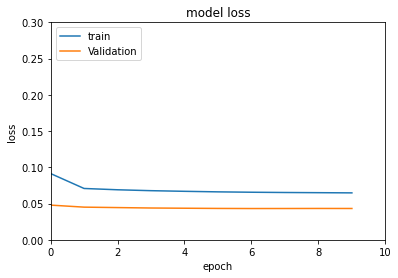

In [20]:
validation_curve(model.history)

In [21]:
def mse_curve(model):

    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.axis([0,10,0,0.3])
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()

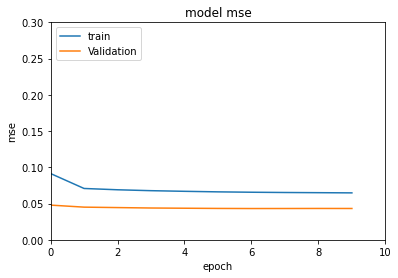

In [22]:
mse_curve(model.history)

In [23]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print(r2_score(Y_test,y_pred))

0.9414396486267471


In [24]:
yhat = deep_learner.predict()

In [25]:
yhat

[0.33898225,
 0.3486194,
 0.8217423,
 0.52086675,
 0.53048956,
 0.50578016,
 0.49137512,
 0.5043831,
 1.1595566,
 1.3098919,
 0.4612382,
 0.5191877,
 0.4849566,
 0.57648206,
 0.60199285,
 0.5180906,
 0.5046455,
 0.51129985,
 0.51914775,
 0.7844709,
 0.69420874,
 0.61513436,
 0.51546514,
 0.47981855,
 0.5102247,
 0.50567687,
 0.46572632,
 0.46089423,
 0.4459719,
 0.44481307,
 0.6452818,
 0.61632264,
 1.9194133,
 2.2210612,
 2.1936638,
 1.7352084,
 1.1126807,
 0.57927704,
 1.6471047,
 1.5318608,
 1.8029008,
 1.88242,
 2.1533482,
 1.7174627,
 1.558046,
 1.4599018,
 1.525095,
 1.5380776,
 2.6814115,
 3.2177339,
 3.2266052,
 2.3162727,
 3.026597,
 3.262918,
 3.5353208,
 3.5440118,
 3.0094519,
 3.4814131,
 2.209629,
 2.3374817,
 3.0380745,
 3.2691755,
 3.0881834,
 2.682414,
 2.5965033,
 2.4352717,
 2.511868,
 2.4365385,
 2.397263,
 2.322932,
 2.2773283,
 2.2976112,
 2.2355006,
 2.1909187,
 2.260514,
 2.1648512,
 2.271103,
 2.22565,
 2.233743,
 2.2615163,
 2.2162185,
 2.2197435,
 2.2516294,
 

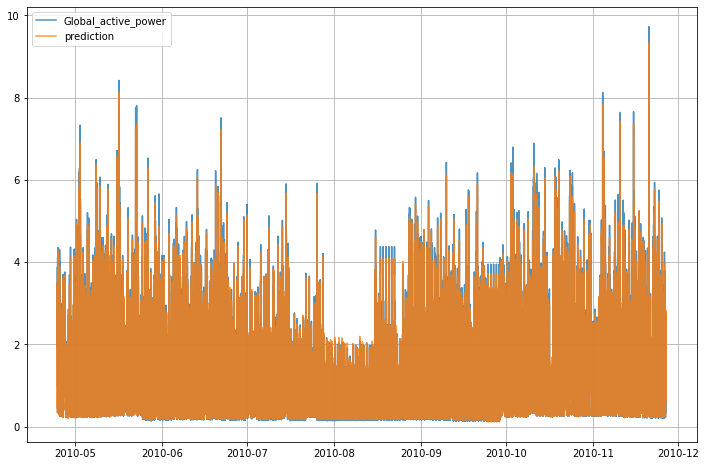

In [26]:
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['prediction'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Global_active_power', 'prediction']:
  plt.plot(
    'datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

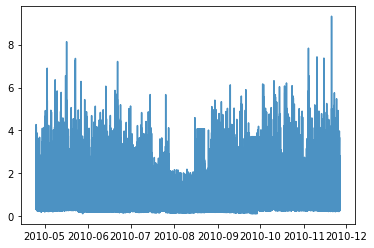

In [28]:
plt.plot(
    'datetime',
    "prediction",
    data=fc,
    label=dtype,
    alpha=0.8
  )

In [ ]:
plt.plot(
    'datetime',
    "Global_active_power",
    data=fc,
    label=dtype,
    alpha=0.8
  )

## Save the model

In [62]:
from tensorflow.keras.models import save_model, load_model

# ##### ##### ##### SAVE MODEL JUST ONE TIME ##### ##### #####
save_model(model,'model.h5')